<div class="text_cell_render rendered_html" tabindex="-1">
    <p><img src="https://datascientest.fr/train/assets/logo_datascientest.png" style="height: 150px"></p>
    <p></p><hr style="border-width: 2px ; border-color: #75dfc1"><p></p>
    <p></p><h1 style="text-align: center" id="-Etude-d-un-modèle-"> Etude d'un modèle <a class="anchor-link" href="#-Etude-d-un-modèle-">¶</a></h1><p></p>
    <p></p><h2 style="text-align: center" id="-Introduction-"> Introduction <a class="anchor-link" href="#-Introduction-">¶</a></h2><p></p>
    <hr style="border-width: 2px ; border-color: #75dfc1">
    <blockquote>
        <p>Dans ce note book, on se propose de tester et valider les preformances d'un CNN pour lequel on a déjà fait une première prévalidation pour essayer de déterminer le meilleur "learning rate".</p>
        <p>Donc, le modèle à été testé sur un jeux en niveau de gris puis en couleur, et on a pris le meilleur "learning rate" pour chacun des cas.</p><br><br>
        <p>Par conséquent, on va tester les performances avec ce modèle avec le "learning rate" correspondant sur des images en niveaux de gris, puis en couleur. Et ceci sera fait sur un jeux de 4 classes, puis 15 classes, correspondant à la combinaison de nos classes "primaires".</p>
    </blockquote>
    
</div>

# Première Partie - Préparation de l'environnement

## 1 - Importation des différentes librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from os import listdir

from numpy import zeros
from numpy import asarray
from numpy import savez_compressed

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

import itertools

import cv2

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.optimizers import SGD, Adam

from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D 
from keras.layers import AveragePooling2D, GlobalAveragePooling2D

from tensorflow.keras import callbacks
from tensorflow import keras

## 2 - Définition des fonctions nécessaires

### a - Fonction de génération d'images

Via la méthode ImageDataGenerator, nous allons définir un générateur qui va nous permettre d'appliquer un certain nombre de transformations à nos images.

La nature même des images traitées (photos satellite de zone nuageuses) laissent une marge de manoeuvre relativement faible quant aux augmentations possibles. Nous avons opté pour les transformations suivantes :
- une normalisation
- des symétries horizontales et verticales
- des rotations aléatoires de l'ordre de 90 degrés
- on peut également procéder à des translations

Les images peuvent par ailleurs être converties en nuances de gris par le générateur en fonction du paramètre sur la valeur du canal.
Enfin leur taille est divisee par 10.

A noter qu'en cas de transfert learning, la majorité des modèles veulent du rgb en entree (donc 3 canaux)

On choisit de positionner l'argument fill_mode à "constant" pour que le vide soit comblé par une couleur unie et non déterminé par le pixel le plus proche.

In [2]:
def image_data_generator(X, classes, canal, validationSplit = 0.2):
    """
        Définition: Cette fonction procède à la génération
        d'images déformées supplémentaires pour l'entrainement 
        du modèle.
        
        Paramètres:
            @X : Le fichier contenant les informations sur les images et
            les classes contenues dans l'image
            @lesClasses : correspond aux classes pour les tests
            @canal : Permet de générer des images en couleur ou en
            niveau de gris
            validationSplit : crée un ensemble de données de validation
            
        Return: La fonction renvoie deux jeux de données pour le training et la validation
    """
       
    if canal == 1:
        mode_color = "grayscale"
    else:
        mode_color = "rgb"

    datagen = ImageDataGenerator(rescale = 1./255, 
                                 horizontal_flip = True,
                                 vertical_flip = True,
                                 rotation_range = 20,
                                 fill_mode = 'constant',
                                 width_shift_range = 0.1,
                                 height_shift_range = 0.1,
                                 zoom_range = .1,                             
                                 validation_split = validationSplit)

    train_generator = datagen.flow_from_dataframe(
        dataframe = X,
        directory = repTrain,
        x_col = 'image',
        y_col = classes,
        subset = 'training',
        class_mode = 'raw',
        shuffle = True,                    ## On melange tout
        color_mode = mode_color,          ## On passe en nuance de gris
        target_size = (image_width, image_height), ## On divise la taille par 10
        batch_size = batch_size, 
        seed = 42) ## On fixe le seed pour comparer sur les même mélanges

    validation_generator = datagen.flow_from_dataframe(
        dataframe = X,
        directory = repTrain,
        x_col = 'image',
        y_col = classes,
        subset = 'validation',
        class_mode = 'raw',
        shuffle = True,
        color_mode = mode_color,
        target_size = (image_width, image_height),
        batch_size = batch_size, 
        seed = 42)
    
    return train_generator, validation_generator


### b - Fonction d'affichage d'images

Ici, on a une fonction qui permet de visualiser la première image avec les déformations appliquées.

In [3]:
# On affiche la premiere image, qui peut changer a chaque execution puisque nous avons effectue un shuffle
# La premiere image est affichee ainsi que les augmentations qu'elle a subit
def plotImages(images_arr, canal):
    
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    
    axes = axes.flatten()
    
    for img, ax in zip( images_arr, axes):

        ## Affichage en fonction du mode d'image
        if canal == 1:
            
            ## Les images physiques sont en rgb mais en grayscale dans le generateur,
            ## par consequent il faut repasser de 1 a 3 canaux
            stacked_img = np.squeeze(np.stack((img,) * 3, -1)) 
            
            ax.imshow(stacked_img, cmap='gray')
            
        else:
            img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img_color)
    
    plt.tight_layout()
    
    plt.show()


### c - Fonction qui prépare un jeux de test pour la prédiction

Pour pouvoir évaluer notre modèle, on prépre un jeux de test. Le jeux de test doit être adapté aux modèle. Il faut donc préciser si on veux un jeux en niveaux de gris ou en couleur.

In [4]:
def convert_image(X, canaux, repPath):
    """
        Fonction qui produit un tableau d'image pour la prédiction
        
        Paramètre:
            @X : Le fichier contenant les le noms des images et les classes
            
            @canaux = permet de définir le nombre de canaux (1 ou 3)
            
            @repPath: répertoire contenant les images
        
        Return : Un tableau d'images et les classes présentent
    """
    
    X_img=[]
    
    for image in X:
        
        path = repPath + image
        
        ## Load image
        if canaux == 3:
            img = cv2.imread(path)
        else:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        
        ## Resize image
        img = cv2.resize(img,(image_width,image_height))
        
        ## for the black and white image
        img = img.reshape([image_width,image_height,canaux])
            
        ## cv2 load the image BGR sequence color (not RGB)
        X_img.append(img[...,::-1])
        
    return np.array(X_img)



### d - Fonction qui crée le modèle à tester

Ici, on a une fonction qui crée un modèle CNN

In [5]:
def creation_model(nb_classes, canaux, affichage = False):
    """
        Paramètres:
        
            @nb_classes : permets de définir le nombre de neuronnes
                de la dernière couche

            @canaux = permet de définir le nombre de canaux (1 ou 3)

            affichage : Permet d'afficher le résumé du modèle
        """
    model = Sequential()

    model.add(Conv2D(filters = 192,
                       kernel_size = (7,7),
                       input_shape=(image_width, image_height,canaux),
                       padding = 'valid',
                       activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 256,
                     kernel_size = (3,3),
                     padding = 'valid',
                     activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 512,
                     kernel_size = (3,3),
                     padding = 'valid',
                     activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 1024,
                     kernel_size = (3,3),
                     padding = 'valid',
                     activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 1024,
                     kernel_size = (3,3),
                     padding = 'valid',
                     activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024,
                    activation = 'elu'))

    model.add(Dense(4096,
                    activation = 'elu'))
    model.add(Dropout(0.2))

    model.add(Dense(nb_classes, activation='sigmoid'))

    if affichage == True:
        model.summary()
        
    return model

### e - Définition de nos fonctions callback

On va définir trois fonction de callbacks:
- Une pour sauvegarder les poids,
- Une autre pour modfifier le learning rate en cas de stagnation de la fonction loss,
- Un dernière pour stopper l'apprentissage si le modèle n'évolue plus.

In [6]:
checkpoint = callbacks.ModelCheckpoint(filepath='checkpoint',
                                       monitor='val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         verbose = 2,
                                         factor=0.1,
                                         mode = 'min')

e_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                     patience = 5,
                                     mode = 'min',
                                     restore_best_weights = True)

### f - Affichage graphiques

Fonction qui affiche les graphiques d'évolution de la fonction de perte, ainsi que de la fonction Accuracy.

In [7]:
def affiche_resultat(history, epoch, lr):
    """
        La fonction affiche un graphe pour la fonction Accuracy 
        et un autre pour la fonction Loss
        
        Paramètre:
            @history : tenseur contenant les résultat de l'entrainement
            
            @epoch : le nombre de génération utilisé par le modèle pour l'entrainement
            
            @lr : le paramètre learning rate utilisé
    """
    
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize = (14,5))
    plt.suptitle(f"Résultats obtenus avec un learning rate de {lr}")
    
    epoques = np.arange(1, epoch+1, 1)
    
    ## Labels des axes
    plt.subplot(121) 
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    ## Courbe de la précision sur l'échantillon d'entrainement
    plt.plot(epoques,
             train_accuracy,
             label = 'Training Accuracy',
             color = 'blue')

    ## Courbe de la précision sur l'échantillon de validation
    plt.plot(epoques,
             val_accuracy,
             label = 'Validation Accuracy',
             color = 'red')

    ## Affichage de la légende
    plt.legend()

    plt.subplot(122) 
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    ## Courbe de la précision sur l'échantillon d'entrainement
    plt.plot(epoques,
             train_loss,
             label = 'Training loss',
             color = 'blue')

    ## Courbe de la précision sur l'échantillon de validation
    plt.plot(epoques,
             val_loss,
             label = 'Validation loss',
             color = 'red')

    ## Affichage de la légende
    plt.legend()
    
    ## Affichage de la figure
    plt.show()

## 3 - Préparation des données pour les tests

### a - Les données communes

Ici, on commence à préparer les données pours les tests.    
On va donc faire une première préparation de base, qui va nous permettre en suite, de créer le jeux pour l'étude sur 4 classes et sur 15 classes.

In [8]:
## Répertoires contenant les images
repTrain  = 'train_images/'
repTest   = 'test_images/'

In [9]:
## Chargement du fichier train.csv
train = pd.read_csv('train.csv')

## Séparation nom de fichier / label
sep = '_'
train['image'] = train['Image_Label'].apply(lambda x: x.split(sep)[0])
train['label'] = train['Image_Label'].apply(lambda x: x.split(sep)[1])
train = train.drop(['Image_Label'], axis=1)

## Suppression des labels sans zone identifiées (variable EncodedPixels a NaN)
train = train.dropna()

## One Hot Encoding des classes de nuages et suprression des variables label et EncodedPixels
## On effectue une dichotomisation des classes de nuages
train_encoded = train
train_encoded= train_encoded.join(pd.get_dummies(train_encoded['label']))

## On supprime ensuite les colonnes "encoded Pixels" et "label", inutiles pour l'aggregation qui suit
train_encoded = train_encoded.drop(['EncodedPixels', 'label'], axis=1)

## Enfin on fait un sous-total pour ne conserver qu'une ligne par image
train_encoded = train_encoded.groupby(['image']).sum()

train_encoded = train_encoded.reset_index(level=0)
train_encoded.head()

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,1,1,0,0
1,002be4f.jpg,1,1,0,1
2,0031ae9.jpg,1,1,0,1
3,0035239.jpg,0,1,1,0
4,003994e.jpg,1,0,1,1


A partir de maintenant, on crée des jeux adaptés à chaque traitement.

### b - Jeux pour le test sur 4 classes

Ici, on peut utiliser train_encoded tel quel, il nous faut juste définir la liste des classes pour la génération d'images.

In [10]:
classes = ['Fish', 'Flower', 'Gravel', 'Sugar']

Maintenant, on va séparer le jeux en deux. Un pour l'entrainement, et qui sera utilisé dans le générateur et lautre qui ne servira que pour le test du modèle et pour les analysees.

In [11]:
## On prend 20 % pour le test.
## On fixe le random_state à 42 pour utiliser le même jeux de données quelques soit les tests
train_encoded_train, train_encoded_test = train_test_split(train_encoded, 
                                                           test_size = 0.2, 
                                                           random_state = 42)

### c - Jeux pour le test sur 15 classes

Ici, on repart de train_encoded et on crée le jeux pour ce type de test.

In [12]:
## On crée une colonne avec la combinaison des 4 classes primaires
train_encoded['classes']= train_encoded['Fish']*1000 +\
    train_encoded['Flower']*100 +\
    train_encoded['Gravel']*10 +\
    train_encoded['Sugar']

## On crée un nouveau dataframe sans les colonnes des classes primaires
train_encoded_15 = train_encoded.drop(['Fish','Flower','Gravel','Sugar'], axis = 1)

## On "dummies" nos 15 classes
train_encoded_15 = train_encoded_15.join(pd.get_dummies(train_encoded['classes'], prefix='cl' ))

## On supprimme la colonnes contenant les 15 classes
train_encoded_15 = train_encoded_15.drop('classes', axis = 1)

train_encoded_15.head()

,image,cl_1,cl_10,cl_11,cl_100,cl_101,cl_110,cl_111,cl_1000,cl_1001,cl_1010,cl_1011,cl_1100,cl_1101,cl_1110,cl_1111
0,0011165.jpg,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,002be4f.jpg,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0031ae9.jpg,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0035239.jpg,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,003994e.jpg,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [13]:
## Définit nos classes:
classes_15 = ['cl_1','cl_10','cl_11','cl_100','cl_101','cl_110','cl_111','cl_1000',
           'cl_1001','cl_1010','cl_1011','cl_1100','cl_1101','cl_1110','cl_1111']

In [14]:
# Comme pour le cas des 15 classes, on split nos données
# On prend 20 % pour le test
train_encoded_15_train, train_encoded_15_test = train_test_split(train_encoded_15, 
                                                           test_size = 0.2, 
                                                           random_state = 42)

# Seconde Partie - Les tests

In [15]:
# On définit nos variables globales
batch_size = 32
image_width = 140
image_height = 210

## 1 - Test sur 4 classes

### a - Test en niveaux de gris

#### a.1. - Génération des images pour l'entrainement

In [16]:
## On appelle la fonction qui génére les jeux
train_generator, validation_generator = image_data_generator(train_encoded_train, classes, 1)

Found 3549 validated image filenames.
Found 887 validated image filenames.


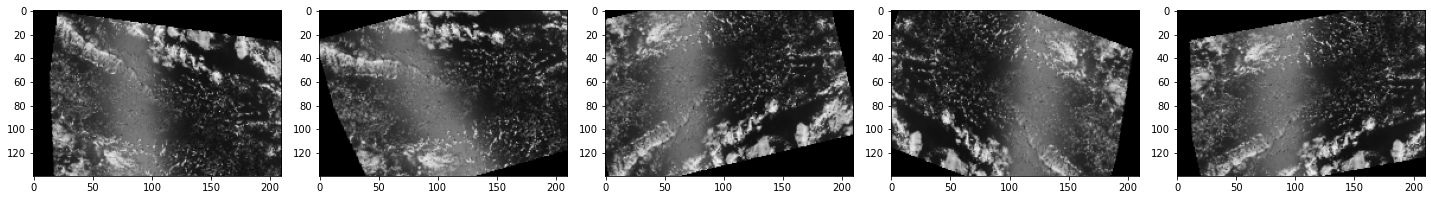

In [17]:
## On affiche la premiere image, qui peut changer a chaque execution puisque nous avons effectue un shuffle
## La premiere image est affichee ainsi que les augmentations qu'elle a subit
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, 1)

#### a.2. - Entraînement du modèle

In [17]:
## On crée le modèle
model3_4cl_gris = creation_model(nb_classes = 4, canaux = 1, affichage = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 134, 204, 192)     9600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 102, 192)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 100, 256)      442624    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 50, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 48, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 24, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 22, 1024)      4

In [19]:
## On compile le modèle
lr = 1e-5
model3_4cl_gris.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# On entraine le modèle sur 50 époques
EPOCHS = 50
STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=validation_generator.n//batch_size

history = model3_4cl_gris.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
110/110 [==============================] - 489s 4s/step - loss: 0.6806 - accuracy: 0.0966 - val_loss: 0.6788 - val_accuracy: 0.0706
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/50
110/110 [==============================] - 490s 4s/step - loss: 0.6726 - accuracy: 0.0854 - val_loss: 0.6710 - val_accuracy: 0.0694
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/50
110/110 [==============================] - 488s 4s/step - loss: 0.6663 - accuracy: 0.0992 - val_loss: 0.6628 - val_accuracy: 0.0799
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/50
110/110 [==============================] - 490s 4s/step - loss: 0.6429 - accuracy: 0.1523 - val_loss: 0.6463 - val_accuracy: 0.2106
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 5/50
110/110 [==============================] - 489s 4s/step - loss: 0.6367 - accuracy: 0.1831 - val_loss: 0.6291 - val_accuracy: 0.1366
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 6/50
110/110 [

#### a.3. - Evaluation du modèle

On commence par afficher les courbes d'évolution de l'accuracy et de la loss.

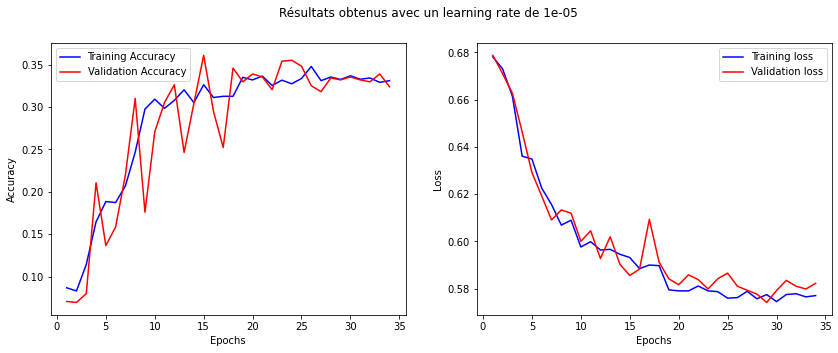

In [21]:
## On fait appel à la fonction qui affiche la=es courbess.
epochTrain = len(history.history['loss'])
affiche_resultat(history, epochTrain, lr)

Maintenant, on va faire une prédiction sur le jeux de test.

In [22]:
## On prépare le jeux de test avec la fonction convert_image(X, canaux, repPath):
X_test = train_encoded_test['image']
y_test = train_encoded_test[classes]

X_test_img = convert_image(X_test, 1, repTrain)

In [23]:
## On fait des prédictions
y_pred = model3_4cl_gris.predict(X_test_img).round()


In [24]:
## On affiche le rpport de classification
print(classification_report(y_test, y_pred, target_names = classes))

              precision    recall  f1-score   support

        Fish       0.00      0.00      0.00       573
      Flower       0.42      1.00      0.59       469
      Gravel       0.00      0.00      0.00       599
       Sugar       0.00      0.00      0.00       759

   micro avg       0.42      0.20      0.27      2400
   macro avg       0.11      0.25      0.15      2400
weighted avg       0.08      0.20      0.12      2400
 samples avg       0.42      0.20      0.26      2400



/home/joca/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
## On affiche le score et la loss du modèle
scores = model3_4cl_gris.evaluate(X_test_img, y_test, verbose=0)
print("%s: %.2f" % (model3_4cl_gris.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model3_4cl_gris.metrics_names[1], scores[1]*100))

loss: 43.84
accuracy: 22.88%


In [26]:
##On affiche la table de confusion
## Pour afficher la matrice de confusion on transforme y_pred
y_pred_df = pd.DataFrame(y_pred, index = y_test.index, columns = classes)

### Affichage de la matrice de confusion avec multilabel_confusion_matrix
cnf_matrix = multilabel_confusion_matrix(y_test, y_pred_df)
print(cnf_matrix)


[[[537   0]
  [573   0]]

 [[  0 641]
  [  0 469]]

 [[511   0]
  [599   0]]

 [[351   0]
  [759   0]]]


### b - Test en couleurs

#### b.1. - Génération des images pour l'entrainement

In [27]:
## On appelle la fonction qui génére les jeux
train_generator, validation_generator = image_data_generator(train_encoded_train, classes, 3)

Found 3549 validated image filenames.
Found 887 validated image filenames.


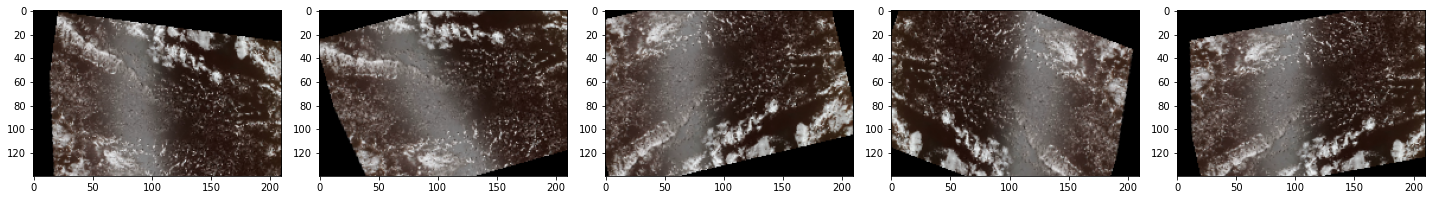

In [28]:
## On affiche la premiere image, qui peut changer a chaque execution puisque nous avons effectue un shuffle
## La premiere image est affichee ainsi que les augmentations qu'elle a subit
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images, 3)

#### b.2. - Entraînement du modèle

In [29]:
## On crée le modèle
model3_4cl_color = creation_model(nb_classes = 4, canaux = 3, affichage = False)

In [30]:
## On compile le modèle
lr = 1e-5
model3_4cl_color.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
# On entraine le modèle sur 50 époques
EPOCHS = 50
STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=validation_generator.n//batch_size

history = model3_4cl_color.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
110/110 [==============================] - 499s 5s/step - loss: 0.6789 - accuracy: 0.1021 - val_loss: 0.6764 - val_accuracy: 0.0706
Epoch 2/50
110/110 [==============================] - 500s 5s/step - loss: 0.6727 - accuracy: 0.0752 - val_loss: 0.6566 - val_accuracy: 0.0764
Epoch 3/50
110/110 [==============================] - 486s 4s/step - loss: 0.6491 - accuracy: 0.1320 - val_loss: 0.6346 - val_accuracy: 0.1551
Epoch 4/50
110/110 [==============================] - 481s 4s/step - loss: 0.6365 - accuracy: 0.1696 - val_loss: 0.6395 - val_accuracy: 0.2176
Epoch 5/50
110/110 [==============================] - 481s 4s/step - loss: 0.6231 - accuracy: 0.1940 - val_loss: 0.6171 - val_accuracy: 0.2269
Epoch 6/50
110/110 [==============================] - 480s 4s/step - loss: 0.6199 - accuracy: 0.1973 - val_loss: 0.6279 - val_accuracy: 0.2037
Epoch 7/50
110/110 [==============================] - 479s 4s/step - loss: 0.6170 - accuracy: 0.2071 - val_loss: 0.6035 - val_accuracy: 0.2593

#### b.3. - Evaluation du modèle

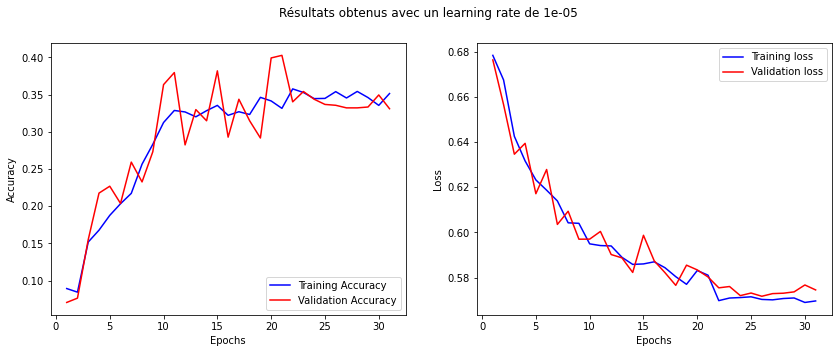

In [32]:
## On fait appel à la fonction qui affiche la=es courbess.
epochTrain = len(history.history['loss'])
affiche_resultat(history, epochTrain, lr)

In [33]:
## On prépare le jeux de test avec la fonction convert_image(X, canaux, repPath):
X_test = train_encoded_test['image']
y_test = train_encoded_test[classes]

X_test_img_color = convert_image(X_test, 3, repTrain)

In [34]:
## On fait des prédictions
y_pred_color = model3_4cl_color.predict(X_test_img_color).round()

In [35]:
## On affiche le rpport de classification
print(classification_report(y_test, y_pred_color, target_names = classes))

              precision    recall  f1-score   support

        Fish       0.00      0.00      0.00       573
      Flower       0.42      1.00      0.59       469
      Gravel       0.00      0.00      0.00       599
       Sugar       1.00      0.01      0.01       759

   micro avg       0.42      0.20      0.27      2400
   macro avg       0.36      0.25      0.15      2400
weighted avg       0.40      0.20      0.12      2400
 samples avg       0.42      0.21      0.27      2400



/home/joca/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
## On affiche le score et la loss du modèle
scores = model3_4cl_color.evaluate(X_test_img_color, y_test, verbose=0)
print("%s: %.2f" % (model3_4cl_color.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model3_4cl_color.metrics_names[1], scores[1]*100))

loss: 41.62
accuracy: 22.88%


In [37]:
##On affiche la table de confusion
## Pour afficher la matrice de confusion on transforme y_pred
y_pred_color_df = pd.DataFrame(y_pred_color, index = y_test.index, columns = classes)

### Affichage de la matrice de confusion avec multilabel_confusion_matrix
cnf_matrix = multilabel_confusion_matrix(y_test, y_pred_color_df)
print(cnf_matrix)

[[[537   0]
  [573   0]]

 [[  0 641]
  [  0 469]]

 [[511   0]
  [599   0]]

 [[351   0]
  [755   4]]]


## 2 - Test sur 15 classes

### a - Test en niveaux de gris

#### a.1. - Génération des images pour l'entrainement

In [16]:
## On appelle la fonction qui génére les jeux
train_generator, validation_generator = image_data_generator(train_encoded_15_train, classes_15, 1)

Found 3549 validated image filenames.
Found 887 validated image filenames.


#### a.2. - Entraînement du modèle

In [17]:
## On crée le modèle
model3_15cl_gris = creation_model(nb_classes = 15, canaux = 1, affichage = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 134, 204, 192)     9600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 67, 102, 192)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 100, 256)      442624    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 50, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 48, 512)       1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 24, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 22, 1024)      4

In [24]:
model3_15cl_gris = keras.models.load_model('checkpoint')

In [40]:
## On compile le modèle
lr = 1e-5
model3_15cl_gris.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
# On entraine le modèle sur 50 époques
EPOCHS = 50
STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=validation_generator.n//batch_size

history = model3_15cl_gris.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
110/110 [==============================] - 490s 4s/step - loss: 0.3926 - accuracy: 0.0893 - val_loss: 0.2449 - val_accuracy: 0.1238
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/50
110/110 [==============================] - 500s 5s/step - loss: 0.2451 - accuracy: 0.1289 - val_loss: 0.2442 - val_accuracy: 0.1238
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 3/50
110/110 [==============================] - 522s 5s/step - loss: 0.2448 - accuracy: 0.1230 - val_loss: 0.2430 - val_accuracy: 0.1227
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/50
110/110 [==============================] - 515s 5s/step - loss: 0.2415 - accuracy: 0.1408 - val_loss: 0.2421 - val_accuracy: 0.1250
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 5/50
110/110 [==============================] - 518s 5s/step - loss: 0.2405 - accuracy: 0.1481 - val_loss: 0.2422 - val_accuracy: 0.1447
Epoch 6/50
110/110 [==============================] - 498s 5s/step - loss

110/110 [==============================] - 491s 4s/step - loss: 0.2145 - accuracy: 0.2443 - val_loss: 0.2162 - val_accuracy: 0.2407
Epoch 48/50
110/110 [==============================] - 489s 4s/step - loss: 0.2141 - accuracy: 0.2451 - val_loss: 0.2155 - val_accuracy: 0.2396


#### a.3. - Evaluation du modèle

On commence par afficher les courbes d'évolution de l'accuracy et de la loss.

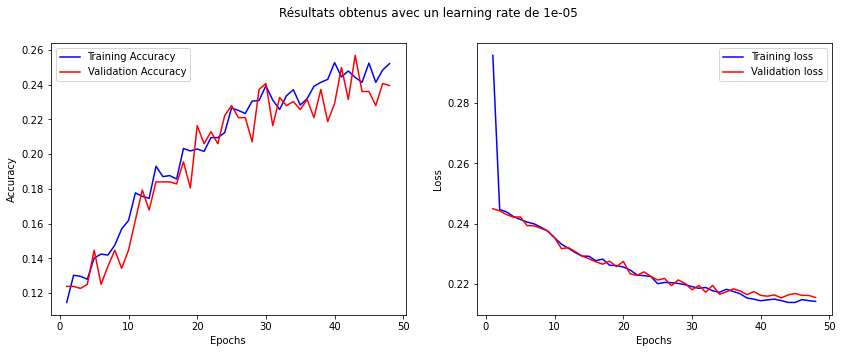

In [42]:
## On fait appel à la fonction qui affiche la=es courbess.
epochTrain = len(history.history['loss'])
affiche_resultat(history, epochTrain, lr)

Maintenant, on va faire une prédiction sur le jeux de test.

In [25]:
## On prépare le jeux de test avec la fonction convert_image(X, canaux, repPath):
X_test = train_encoded_15_test['image']
y_test = train_encoded_15_test[classes_15]

X_test_img = convert_image(X_test, 1, repTrain)

In [26]:
## On fait des prédictions
y_pred = model3_15cl_gris.predict(X_test_img).round()


In [27]:
## On affiche le rpport de classification
print(classification_report(y_test, y_pred, target_names = classes_15))

              precision    recall  f1-score   support

        cl_1       0.00      0.00      0.00        78
       cl_10       0.00      0.00      0.00        59
       cl_11       0.00      0.00      0.00       146
      cl_100       0.06      1.00      0.11        67
      cl_101       0.00      0.00      0.00        92
      cl_110       0.00      0.00      0.00        29
      cl_111       0.00      0.00      0.00        66
     cl_1000       0.00      0.00      0.00        50
     cl_1001       0.00      0.00      0.00       104
     cl_1010       0.00      0.00      0.00        49
     cl_1011       0.00      0.00      0.00       155
     cl_1100       0.05      1.00      0.10        61
     cl_1101       0.00      0.00      0.00        59
     cl_1110       0.00      0.00      0.00        36
     cl_1111       0.00      0.00      0.00        59

   micro avg       0.06      0.12      0.08      1110
   macro avg       0.01      0.13      0.01      1110
weighted avg       0.01   

/home/joca/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
## On affiche le score et la loss du modèle
scores = model3_15cl_gris.evaluate(X_test_img, y_test, verbose=0)
print("%s: %.2f" % (model3_15cl_gris.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model3_15cl_gris.metrics_names[1], scores[1]*100))

loss: 18.49
accuracy: 6.40%


In [29]:
##On affiche la table de confusion
## Pour afficher la matrice de confusion on transforme y_pred
y_pred_df = pd.DataFrame(y_pred, index = y_test.index, columns = classes_15)

### Affichage de la matrice de confusion avec multilabel_confusion_matrix
cnf_matrix = multilabel_confusion_matrix(y_test, y_pred_df)
print(cnf_matrix)

[[[1032    0]
  [  78    0]]

 [[1051    0]
  [  59    0]]

 [[ 964    0]
  [ 146    0]]

 [[   0 1043]
  [   0   67]]

 [[1018    0]
  [  92    0]]

 [[1081    0]
  [  29    0]]

 [[1044    0]
  [  66    0]]

 [[1060    0]
  [  50    0]]

 [[1006    0]
  [ 104    0]]

 [[1061    0]
  [  49    0]]

 [[ 955    0]
  [ 155    0]]

 [[   0 1049]
  [   0   61]]

 [[1051    0]
  [  59    0]]

 [[1074    0]
  [  36    0]]

 [[1051    0]
  [  59    0]]]


In [30]:
X_test_img = X_test_img / 255
y_pred = model3_15cl_gris.predict(X_test_img).round()
print(classification_report(y_test, y_pred, target_names = classes_15))
## On affiche le score et la loss du modèle
scores = model3_15cl_gris.evaluate(X_test_img, y_test, verbose=0)
print("%s: %.2f" % (model3_15cl_gris.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model3_15cl_gris.metrics_names[1], scores[1]*100))
##On affiche la table de confusion
## Pour afficher la matrice de confusion on transforme y_pred
y_pred_df = pd.DataFrame(y_pred, index = y_test.index, columns = classes_15)

### Affichage de la matrice de confusion avec multilabel_confusion_matrix
cnf_matrix = multilabel_confusion_matrix(y_test, y_pred_df)
print(cnf_matrix)

/home/joca/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        cl_1       1.00      0.03      0.05        78
       cl_10       0.05      1.00      0.10        59
       cl_11       0.13      1.00      0.23       146
      cl_100       0.00      0.00      0.00        67
      cl_101       0.00      0.00      0.00        92
      cl_110       0.00      0.00      0.00        29
      cl_111       0.00      0.00      0.00        66
     cl_1000       0.00      0.00      0.00        50
     cl_1001       0.00      0.00      0.00       104
     cl_1010       0.00      0.00      0.00        49
     cl_1011       0.14      1.00      0.25       155
     cl_1100       0.00      0.00      0.00        61
     cl_1101       0.00      0.00      0.00        59
     cl_1110       0.00      0.00      0.00        36
     cl_1111       0.00      0.00      0.00        59

   micro avg       0.11      0.33      0.16      1110
   macro avg       0.09      0.20      0.04      1110
weighted avg       0.11   

### b - Test en couleurs

#### b.1. - Génération des images pour l'entrainement

In [16]:
## On appelle la fonction qui génére les jeux
train_generator, validation_generator = image_data_generator(train_encoded_15_train, classes_15, 3)

Found 3549 validated image filenames.
Found 887 validated image filenames.


#### b.2. - Entraînement du modèle

In [17]:
## On crée le modèle
model3_15cl_color = creation_model(nb_classes = 15, canaux = 3, affichage = False)

In [18]:
## On compile le modèle
lr = 1e-5
model3_15cl_color.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# On entraine le modèle sur 50 époques
EPOCHS = 50
STEP_SIZE_TRAIN=train_generator.n//batch_size
STEP_SIZE_VALID=validation_generator.n//batch_size

history = model3_15cl_color.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VALID,
    callbacks=[lr_plateau, checkpoint, e_stopping])

/home/joca/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
110/110 [==============================] - 478s 4s/step - loss: 0.3762 - accuracy: 0.1096 - val_loss: 0.2434 - val_accuracy: 0.1296
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 2/50
110/110 [==============================] - 485s 4s/step - loss: 0.2455 - accuracy: 0.1292 - val_loss: 0.2440 - val_accuracy: 0.1204
Epoch 3/50
110/110 [==============================] - 492s 4s/step - loss: 0.2443 - accuracy: 0.1278 - val_loss: 0.2430 - val_accuracy: 0.1250
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 4/50
110/110 [==============================] - 500s 5s/step - loss: 0.2414 - accuracy: 0.1319 - val_loss: 0.2417 - val_accuracy: 0.1262
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 5/50
110/110 [==============================] - 501s 5s/step - loss: 0.2399 - accuracy: 0.1459 - val_loss: 0.2406 - val_accuracy: 0.1296
INFO:tensorflow:Assets written to: checkpoint/assets
Epoch 6/50
110/110 [==============================] - 498s 5s/step - loss

#### b.3. - Evaluation du modèle

On commence par afficher les courbes d'évolution de l'accuracy et de la loss.

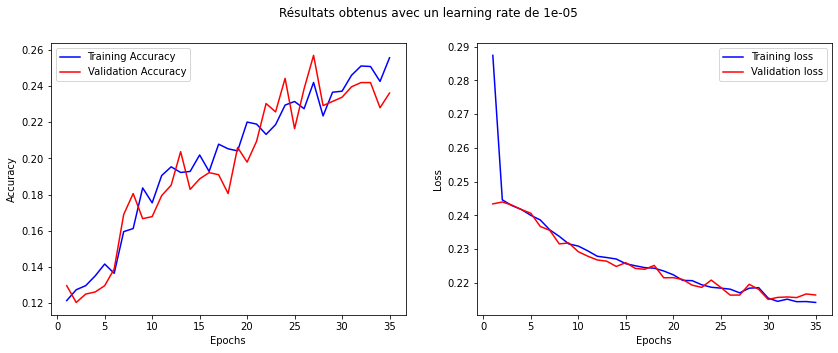

In [20]:
## On fait appel à la fonction qui affiche la=es courbess.
epochTrain = len(history.history['loss'])
affiche_resultat(history, epochTrain, lr)

Maintenant, on va faire une prédiction sur le jeux de test.

In [21]:
## On prépare le jeux de test avec la fonction convert_image(X, canaux, repPath):
X_test = train_encoded_15_test['image']
y_test = train_encoded_15_test[classes_15]

X_test_img = convert_image(X_test, 3, repTrain)

X_test_img = X_test_img / 255

In [22]:
## On fait des prédictions
y_pred = model3_15cl_color.predict(X_test_img).round()

In [23]:
## On affiche le rapport de classification
print(classification_report(y_test, y_pred, target_names = classes_15))

              precision    recall  f1-score   support

        cl_1       0.00      0.00      0.00        78
       cl_10       0.05      1.00      0.10        59
       cl_11       0.13      1.00      0.23       146
      cl_100       0.00      0.00      0.00        67
      cl_101       0.00      0.00      0.00        92
      cl_110       0.00      0.00      0.00        29
      cl_111       0.00      0.00      0.00        66
     cl_1000       0.00      0.00      0.00        50
     cl_1001       0.00      0.00      0.00       104
     cl_1010       0.00      0.00      0.00        49
     cl_1011       0.14      1.00      0.25       155
     cl_1100       0.00      0.00      0.00        61
     cl_1101       0.00      0.00      0.00        59
     cl_1110       0.00      0.00      0.00        36
     cl_1111       0.00      0.00      0.00        59

   micro avg       0.11      0.32      0.16      1110
   macro avg       0.02      0.20      0.04      1110
weighted avg       0.04   

/home/joca/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
## On affiche le score et la loss du modèle
scores = model3_15cl_color.evaluate(X_test_img, y_test, verbose=0)
print("%s: %.2f" % (model3_15cl_color.metrics_names[0], scores[0]))
print("%s: %.2f%%" % (model3_15cl_color.metrics_names[1], scores[1]*100))

loss: 13.85
accuracy: 13.96%


In [65]:
##On affiche la table de confusion
## Pour afficher la matrice de confusion on transforme y_pred
y_pred_df = pd.DataFrame(y_pred, index = y_test.index, columns = classes_15)

### Affichage de la matrice de confusion avec multilabel_confusion_matrix
cnf_matrix = multilabel_confusion_matrix(y_test, y_pred_df)
print(cnf_matrix)

[[[1032    0]
  [  78    0]]

 [[1051    0]
  [  59    0]]

 [[ 964    0]
  [ 146    0]]

 [[1043    0]
  [  67    0]]

 [[1018    0]
  [  92    0]]

 [[1081    0]
  [  29    0]]

 [[1044    0]
  [  66    0]]

 [[1060    0]
  [  50    0]]

 [[1006    0]
  [ 104    0]]

 [[1061    0]
  [  49    0]]

 [[ 955    0]
  [ 155    0]]

 [[1049    0]
  [  61    0]]

 [[1051    0]
  [  59    0]]

 [[1074    0]
  [  36    0]]

 [[1051    0]
  [  59    0]]]
